In [1]:
import pandas as pd
import json
import numpy as np


from imagedata_NeoroScan import *
from image_loading import * 
print("All Prerequisites Loaded Successfully")

Found 3157
Successfully loaded 3157
Found 3453
Successfully loaded 3453
Found 711
Successfully loaded 711
Found 1424
Successfully loaded 1424
Total Training Images: 8745
All Training Images Loaded Successfully!
Found 136
Successfully loaded 136
Found 140
Successfully loaded 140
Found 100
Successfully loaded 100
Found 136
Successfully loaded 136
Total Training Images: 7410
All Training Images Loaded Successfully!
Total Testing Images: 512
All Testing Images loaded successfully!
2.9.1+cpu
2.2.4
11.1.0
 13           RESUME                   0

 14           LOAD_GLOBAL              0 (img)
              LOAD_ATTR                2 (open)
              PUSH_NULL
              LOAD_FAST                0 (image_path)
              CALL                     1
              STORE_FAST               1 (image)

 15           LOAD_GLOBAL              4 (torch)
              LOAD_ATTR                6 (from_numpy)
              PUSH_NULL
              LOAD_GLOBAL              8 (np)
              LO

In [2]:
print("Medical Training Sets =",len(medical_train))
print("Medical Testing Sets =",len(medical_test))

Medical Training Sets = 4
Medical Testing Sets = 4


In [3]:
print("Structure of Training Images :")
str_training = structure_img(medical_train)

Structure of Training Images :
Type: <class 'list'>
Lenght: 4
  Type: <class 'list'>
  Lenght: 3157
    Type: <class 'PIL.Image.Image'>


In [4]:
print("Structure of Testing Images :")
str_testing = structure_img(medical_test)

Structure of Testing Images :
Type: <class 'list'>
Lenght: 4
  Type: <class 'list'>
  Lenght: 136
    Type: <class 'PIL.Image.Image'>


In [5]:
print("Structre Of Glioma Training Images:")
str_glioma_tr = structure_img(glioma_train)

Structre Of Glioma Training Images:
Type: <class 'list'>
Lenght: 3157
  Type: <class 'PIL.Image.Image'>


Diplaying Glioma Images


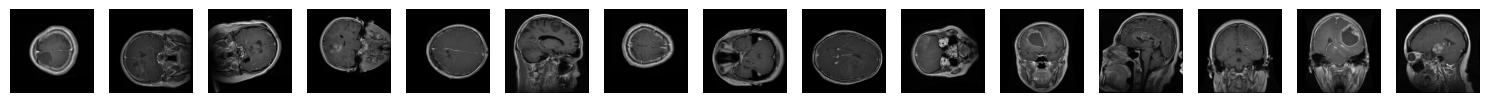

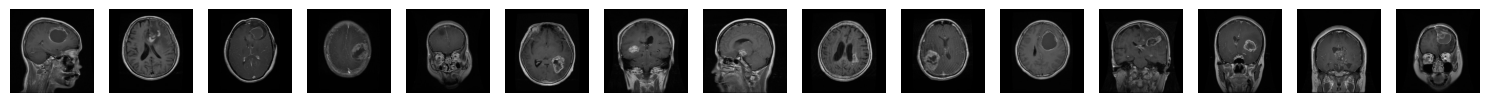

In [6]:
print("Diplaying Glioma Images")
g_train = display_img(glioma_train)
g_test = display_img(glioma_test)

Displaying Meningioma Images


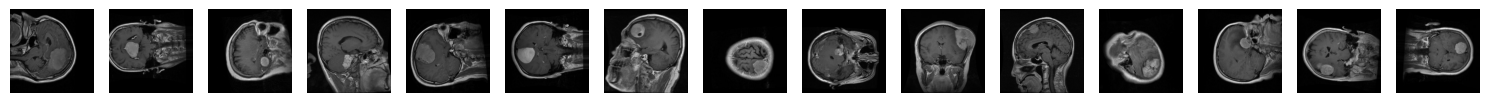

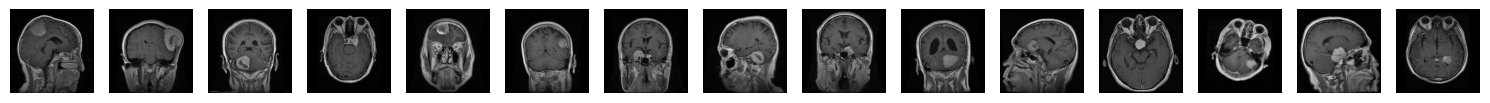

In [7]:
print("Displaying Meningioma Images")

m_train = display_img(meningioma_train)
m_test = display_img(meningioma_test)


Displaying Non Tumor Images


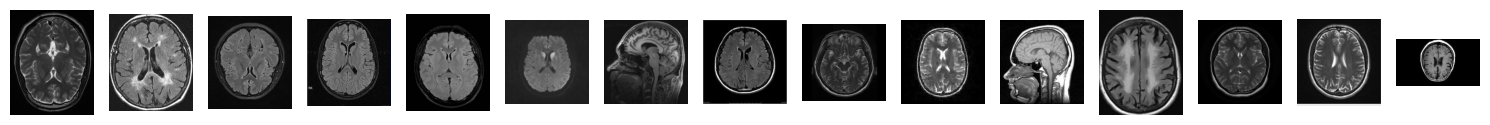

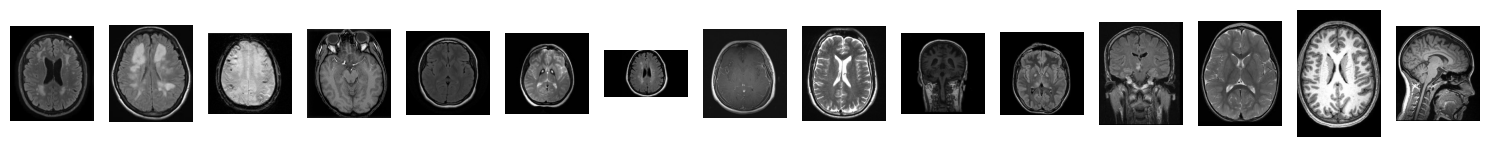

In [8]:
print("Displaying Non Tumor Images")
nt_train = display_img(non_tumor_train)
nt_test = display_img(non_tumor_test)

Displaying Pituitary Tumor Images


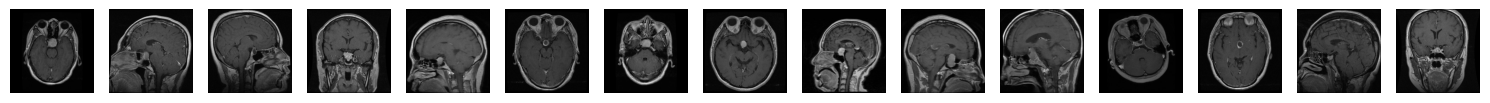

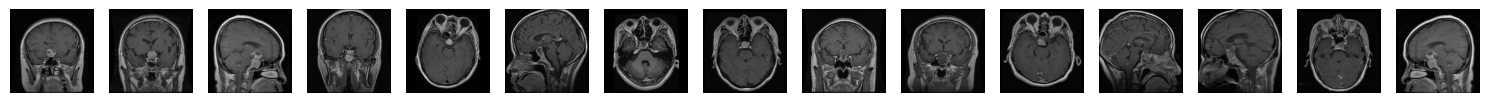

In [9]:
print('Displaying Pituitary Tumor Images')

p_train = display_img(pituitary_train)
p_test = display_img(pituitary_test)

In [10]:
import torch, torchvision.transforms as T
from torchvision import models

model = models.resnet50(pretrained = True)
model = torch.nn.Sequential(*list(model.children()))[:-1]

C:\Users\Tanmay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Tanmay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
print("Vectorising Glioma Training Images")
g_tr = []
for img in glioma_train[:10]:
    prep = T.Compose([T.Resize((256,256)), 
                      T.CenterCrop((224,224)), 
                      T.Grayscale(num_output_channels=3), 
                      T.ToTensor()])
    tensor = prep(img).unsqueeze(0)

    g_tr.append(model(tensor))

print("Vectorising Glioma Testing Images")
g_ts = []

for img in glioma_test[:10]:
    prep = T.Compose([T.Resize((256,256)),
                      T.CenterCrop((224,224)),
                      T.Grayscale(num_output_channels=3),
                      T.ToTensor()])
    tensor = prep(img).unsqueeze(0)
    g_ts.append(model(tensor))

print("Glioma Vectorisation completed !")
print("Glioma Train Data",g_tr,sep= "\n")
print("Glioma Test Data",g_ts,sep="\n")

    

    

Vectorising Glioma Training Images
Vectorising Glioma Testing Images
Glioma Vectorisation completed !
Glioma Train Data
[tensor([[[[0.3333]],

         [[0.5695]],

         [[0.5001]],

         ...,

         [[0.3935]],

         [[0.5147]],

         [[0.4060]]]], grad_fn=<MeanBackward1>), tensor([[[[0.3595]],

         [[0.6004]],

         [[0.5049]],

         ...,

         [[0.3744]],

         [[0.5177]],

         [[0.3598]]]], grad_fn=<MeanBackward1>), tensor([[[[0.3705]],

         [[0.4568]],

         [[0.5036]],

         ...,

         [[0.3586]],

         [[0.4965]],

         [[0.3396]]]], grad_fn=<MeanBackward1>), tensor([[[[0.3660]],

         [[0.5514]],

         [[0.5171]],

         ...,

         [[0.3521]],

         [[0.4850]],

         [[0.3511]]]], grad_fn=<MeanBackward1>), tensor([[[[0.3222]],

         [[0.5465]],

         [[0.5354]],

         ...,

         [[0.3622]],

         [[0.5507]],

         [[0.3657]]]], grad_fn=<MeanBackward1>), tensor([[

In [12]:
print("Vectorising Meningioma Training Images")
m_tr = []
for img in meningioma_train[:10]:
    prep = T.Compose([T.Resize((256,256)),
                      T.CenterCrop((224,224)),
                      T.Grayscale(num_output_channels=3),
                      T.ToTensor()])
    
    tensor = prep(img).unsqueeze(0)
    m_tr.append(model(tensor))

print("Vectorising Meningioma Testing Images")

m_ts = []
for img in meningioma_test[:10]:
    prep = T.Compose([T.Resize((256,256)),
                      T.CenterCrop((224,224)),
                      T.Grayscale(num_output_channels=3),
                      T.ToTensor()])
    tensor = prep(img).unsqueeze(0)
    m_ts.append(model(tensor))

print("Meningioma Vectorisation Completed !")
print("Meningioma Train Data", m_tr, sep="\n")
print("Meningioma Test Data", m_ts, sep="\n")

Vectorising Meningioma Training Images
Vectorising Meningioma Testing Images
Meningioma Vectorisation Completed !
Meningioma Train Data
[tensor([[[[0.3434]],

         [[0.6432]],

         [[0.4737]],

         ...,

         [[0.3672]],

         [[0.4804]],

         [[0.3415]]]], grad_fn=<MeanBackward1>), tensor([[[[0.3631]],

         [[0.5594]],

         [[0.5256]],

         ...,

         [[0.3795]],

         [[0.4665]],

         [[0.3660]]]], grad_fn=<MeanBackward1>), tensor([[[[0.3539]],

         [[0.5532]],

         [[0.4858]],

         ...,

         [[0.3486]],

         [[0.4958]],

         [[0.3405]]]], grad_fn=<MeanBackward1>), tensor([[[[0.3747]],

         [[0.5834]],

         [[0.4819]],

         ...,

         [[0.3698]],

         [[0.4917]],

         [[0.3529]]]], grad_fn=<MeanBackward1>), tensor([[[[0.3676]],

         [[0.4929]],

         [[0.5310]],

         ...,

         [[0.3729]],

         [[0.4782]],

         [[0.3579]]]], grad_fn=<MeanBackwa

In [13]:
# for img_var in medical_train:
#     print("vectorising train set...")
#     print("="*20)
#     vector_train = []

#     for img in img_var[:900]:
        
       
#         prep = prep = T.Compose([T.Resize((256,256)), T.CenterCrop((224,224)),T.Grayscale(num_output_channels= 3), T.ToTensor()])
#         tensor = prep(img).unsqueeze(0)

#         vector_tr = model(tensor)

In [14]:
# for img_var in medical_test:
#     print("vectorising test set...")
#     print("="*20)
#     vector_test = []

#     for img in img_var[:900]:
#         prep = T.Compose([T.Resize((256,256)), T.CenterCrop((224,224)),T.Grayscale(num_output_channels= 3), T.ToTensor()])
#         tensor = prep(img).unsqueeze(0)

#         vector_ts = model(tensor)

In [15]:
# print("Vectorized Training Set:", vector_tr, sep ="\n")
# print(type(vector_tr))

# x_tr = vector_tr.view(vector_tr.size(0), -1)
# x_ts = vector_ts.view(vector_ts.size(0), -1)

In [16]:
# y_tr = np.zeros(x_tr.shape[0], dtype= int)
# y_ts = np.zeros(x_ts.shape[0], dtype= int)

In [17]:
# import pandas as pd
# import numpy as np
# import torch

# def to_numpy(x):
#     if isinstance(x, torch.Tensor):
#         return x.detach().cpu().numpy()
#     return x 

# x_tr = to_numpy(x_tr)
# x_ts = to_numpy(x_ts)
# y_tr = to_numpy(y_tr)
# y_ts = to_numpy(y_ts)

# feature_cols = [f"feat_{i}" for i in range(x_tr.shape[1])]
# print(f"Feature Columns: {len(feature_cols)}")

# df_1 = pd.DataFrame(x_tr, columns = feature_cols)
# df_1["labels"] = y_tr
# df_1["split"] = "train"

# df_2 = pd.DataFrame(x_ts, columns = feature_cols)
# df_2["labels"] = y_ts
# df_2["split"] = "test"

# df = pd.concat([df_1, df_2], ignore_index= True)
# print(df.head())
# print(df["split"].value_counts())








In [18]:
# print("Vectorized Testing Set:", vector_ts, sep="\n")
# print(type(vector_ts))


In [19]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# x_train = df[df.split == "train"].drop(columns=["labels","split"]).values
# y_train = df[df.split == "train"]["labels"].values

# x_test = df[df.split == "test"].drop(columns=["labels" , "split"]).values
# y_test = df[df.split == "test"]["labels"].values

# rf = RandomForestClassifier(
#     n_estimators= 100,
#     random_state=12,
#     verbose= 4,
#     warm_start= True,
#     criterion= "gini",
#     max_samples=0.1


# )

# rf.fit(x_train, y_train)

In [20]:
# x_train

In [21]:
# df.loc[df.sample(frac=0.2 , random_state = 42).index, "split"] = "test"

# x_test = df[df.split == "test"].drop(columns = ["labels", "split"]).values
# y_test = df[df.split == "test"]["labels"].values

In [22]:
# x_test

In [23]:
# from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# y_pred = rf.predict(x_test)
# print("Accuracy:",accuracy_score(y_test, y_pred))
# print("Precision:", precision_score(y_pred, y_test))
# print("Recall:", recall_score(y_pred, y_test))
# print("F1:", f1_score(y_pred, y_test))

In [24]:
# from sklearn.model_selection import train_test_split

# x = np.vstack([x_tr, x_ts])
# y = np.hstack([y_tr, y_ts])

# print(x)
# print(y)





In [25]:
# from sklearn.cluster import KMeans as km

# kmeans = km(
#     n_clusters= 1,
#     random_state= 42,
#     max_iter= 300

    
# )

# print("Model Type Info :: ", type(kmeans))
# print("Model Description ::", kmeans)
# labels = kmeans.fit_predict(x)


In [26]:
# model.eval()

In [27]:
# print("Vectorised Data's Type", sep="/n")
# print(type(vector_tr), type(vector_ts))
# print("Vectorised Data's Shape", sep="/n")
# print("Training Value =",vector_tr.shape,"Testing Value =", vector_ts.shape )
# print("Vectorised Data's Unsqueezed Shape ", sep="/n")
# print("Training UnSqueezed =", vector_tr.unsqueeze(0).shape, "Testing Unsqueezed =", vector_ts.unsqueeze(0).shape)


In [28]:
# print("Structure of Vector Train :")
# str_training_v = structure_img(vector_tr)

# print("Structure of Vector Testing :")
# str_testing_v = structure_img(vector_ts)

In [29]:
# x_tr = (vector_tr.view(vector_tr.size(0), -1)).detach().cpu().numpy()
# x_ts = (vector_ts.view(vector_ts.size(0), -1)).detach().cpu().numpy()

# y_tr = torch.tensor([0] * x_tr.shape[0]).detach().cpu().numpy()
# y_ts = torch.tensor([1] * x_tr.shape[0]).detach().cpu().numpy()

# training_material = x_tr , x_ts, y_tr, y_ts
# print(training_material)

In [30]:
# y_tr = torch.as_tensor(y_tr)
# y_ts = torch.as_tensor(y_ts)

# y = torch.cat([y_tr,y_ts],dim = 0)
# y = y.detach().cpu().numpy()



In [31]:
# print("X_train:", x_tr)
# print("x_test:",x_ts)
# print("y_train:",y_tr)
# print("y_test:",y_ts)

In [32]:
# kmeans_x_cluster = vector_tr.view(vector_tr.size(0), -1)
# kmeans_x_cluster


In [33]:
# print("="*20)
# print("Model Training ...")
# print("="*20)
# cluster = kmeans.fit_predict(kmeans_x_cluster.detach().cpu().numpy())
# print(cluster)

In [34]:
# y_pred = rfc.predict(x_ts)
# print("Y_prediction :", y_pred)


In [35]:
# import torch

# x = torch.cat([vector_tr, vector_ts], dim = 0)
# x = x.view(x.size(0), -1)
# x = x.detach().cpu().numpy()


In [36]:
# print(x)

In [37]:
# from sklearn.cluster import KMeans

# km = KMeans(n_clusters=10, random_state=42, n_init = 10)
# labels = kmeans.fit_predict(x)

# print(km)
# print(labels)